In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batchnum = 64
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchnum, shuffle=True)

Using device: cuda


In [3]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.layers = nn.ModuleDict({
            'fc1': nn.Linear(784, 784),
            'fc2': nn.Linear(784, 784),
            'fc3': nn.Linear(784, 10)  # Output layer for 10 classes
        })

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for i in range(1, 4):
            layer = self.layers[f'fc{i}']
            x = F.relu(layer(x)) if i != 3 else layer(x)
        return x

    def get_layer_name(self, module):
        for name, mod in self.layers.items():
            if mod is module:
                return name
        return None


class ExplainableNetwork:
    def __init__(self, model):
        self.model = model  # Store the reference to the model
        self.node_activations = {}
        self.gradients = {}
        self.current_epoch = 0
        self.node_inputs = []
        self.activations = []
        self.activations_per_input = {}
    

    def input_hook(self, module, num_epochs, input, output):
        if self.current_epoch == num_epochs - 1:
            layer_name = self.model.get_layer_name(module) # Get the layer name
            self.activations.append((layer_name, output.detach().cpu().numpy()))

            for i, single_output in enumerate(output):
                if i not in self.activations_per_input:
                    self.activations_per_input[i] = {}
                self.activations_per_input[i][layer_name] = single_output.detach().cpu().numpy()

            
            for i in range(input[0].size(dim=0)):
                if np.shape(input[0][i]) == torch.Size([784]):
                    image = input[0][i].detach().reshape(28, 28).cpu().numpy()
                    self.node_inputs.append((layer_name, i, image))
        # Store activation values (outputs)
        if isinstance(output, tuple):
            # If output is a tuple, store each element separately
            for idx, out in enumerate(output):
                self.node_activations[(module, idx)] = out.detach().tolist()
        else:
            # If output is a single tensor, store it directly
            self.node_activations[module] = output.detach().tolist()

    def backward_hook(self, module, grad_input, grad_output):
        # grad_output[0] will contain the gradient of the output with respect to the loss
        self.gradients[module] = grad_output[0].detach().tolist()

    def set_epoch(self, epoch):
        self.current_epoch = epoch

    def visualize_activations(self, layer_name, node_index=None):
            # Find the layer data by name
            layer_data = next((layer for lname, layer in self.activations if lname == layer_name), None)
            if layer_data is not None:
                # Visualize activations for the specified node_index or all nodes
                activations = layer_data if node_index is None else layer_data[:, node_index]
                plt.figure(figsize=(10, 6))
                if node_index is not None:
                    plt.plot(activations)
                    plt.title(f'Activations of {layer_name} Node {node_index}')
                else:
                    for i, activation in enumerate(activations.T):  # Transpose for iterating over nodes
                        plt.plot(activation, label=f'Neuron {i}')
                    plt.title(f'Activations of {layer_name} Layer')
                plt.xlabel('Batch')
                plt.ylabel('Activation')
                plt.show()


    def visualize_activations_for_input(self, input_index, layer_name, node_index=None):
        individual_activations = self.activations_per_input.get(input_index, {})
        layer_activations = individual_activations.get(layer_name, None)
        
        if layer_activations is not None:
            # Visualize activations for the specified node_index or all nodes
            plt.figure(figsize=(10, 6))
            if node_index is not None:
                plt.plot(layer_activations[node_index])
                plt.title(f'Activations of {layer_name} Node {node_index} for Input {input_index}')
            else:
                for i, activation in enumerate(layer_activations.T):  # Transpose for iterating over nodes
                    plt.plot(activation, label=f'Neuron {i}')
                plt.title(f'Activations of {layer_name} for Input {input_index}')
            plt.xlabel('Nodes')
            plt.ylabel('Activation')
            plt.show()
        else:
            print(f"No activations found for input {input_index} in layer {layer_name}.")


In [4]:
# Instantiate the model
model = MNISTNet().to(device)
xNetwork = ExplainableNetwork(model)



# Register forward and backward hooks for each layer
for layer_name in ['fc1', 'fc2', 'fc3']:
    layer = model.layers[layer_name]

    # Forward hook
    layer.register_forward_hook(
        lambda module, input, output, x_Network=xNetwork: xNetwork.input_hook(module, num_epochs, input, output)
    )

    # Backward hook
    layer.register_backward_hook(
        lambda module, grad_input, grad_output, x_Network=xNetwork: xNetwork.backward_hook(module, grad_input, grad_output)
    )


In [5]:


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
num_epochs = 2
total_batches = len(trainloader)  # Total number of batches

for epoch in range(num_epochs):
    print("Epoch " + str(epoch + 1))

    # Set the current epoch in ExplainableNetwork
    xNetwork.set_epoch(epoch)

    for batch_num, (inputs, labels) in enumerate(trainloader, 1):  # Start enumeration from 1
        inputs, labels = inputs.to(device), labels.to(device)  # Transfer to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    # You might want to print a new line after each epoch for better readability
    print()


Epoch 1


/home/mazor/nn/nn/lib64/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "



Epoch 2



In [6]:
#for layer_name, neuron_index, batch_index, image in xNetwork.node_inputs:
#    if layer_name == "fc2" and neuron_index > 782:
#        plt.imshow(image, cmap='gray')
#        plt.title(f"Layer: {layer_name}, Neuron: {neuron_index}, Batch: {batch_index}")
#        plt.show()


In [7]:
model.eval()

MNISTNet(
  (layers): ModuleDict(
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=10, bias=True)
  )
)

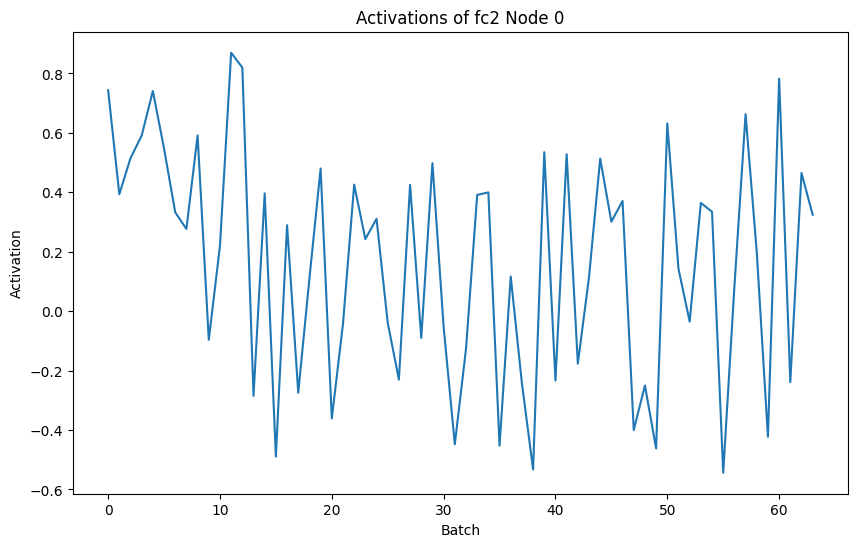

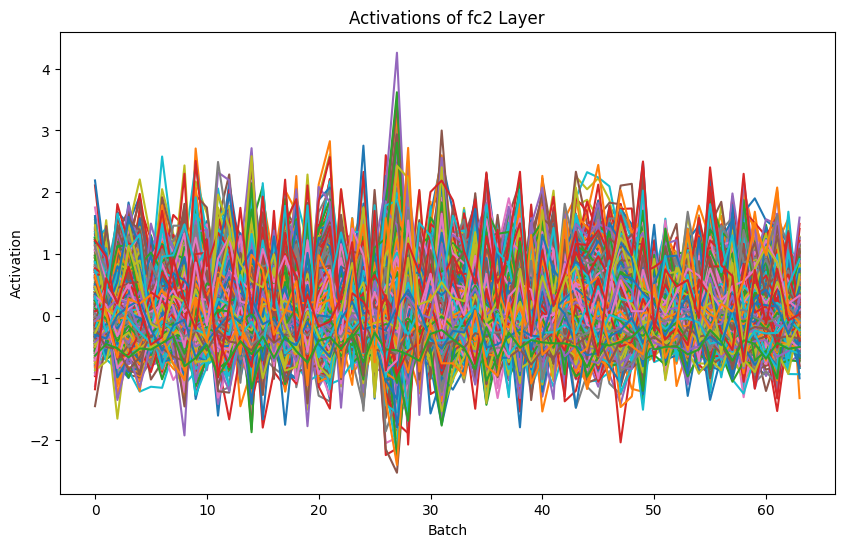

In [8]:
xNetwork.visualize_activations('fc2', node_index=0)  # Visualize for node 0 in fc2
xNetwork.visualize_activations('fc2')  # Visualize for all nodes in fc2


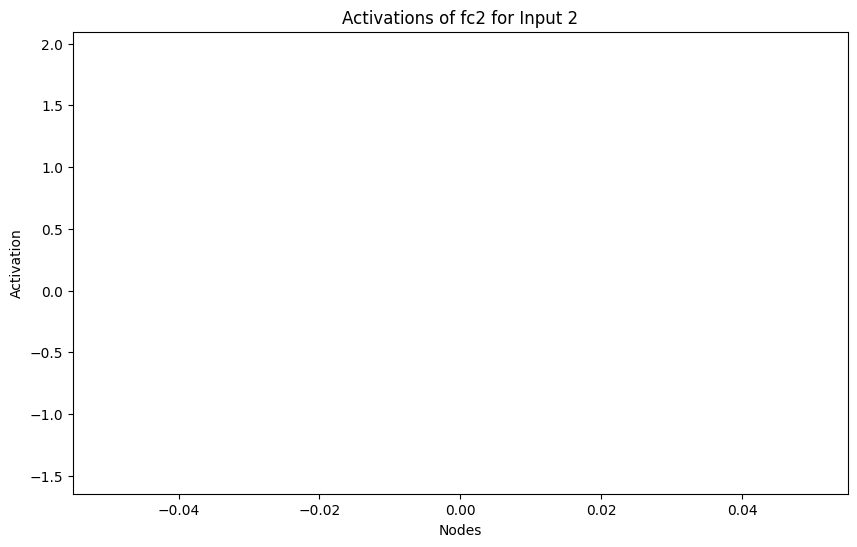

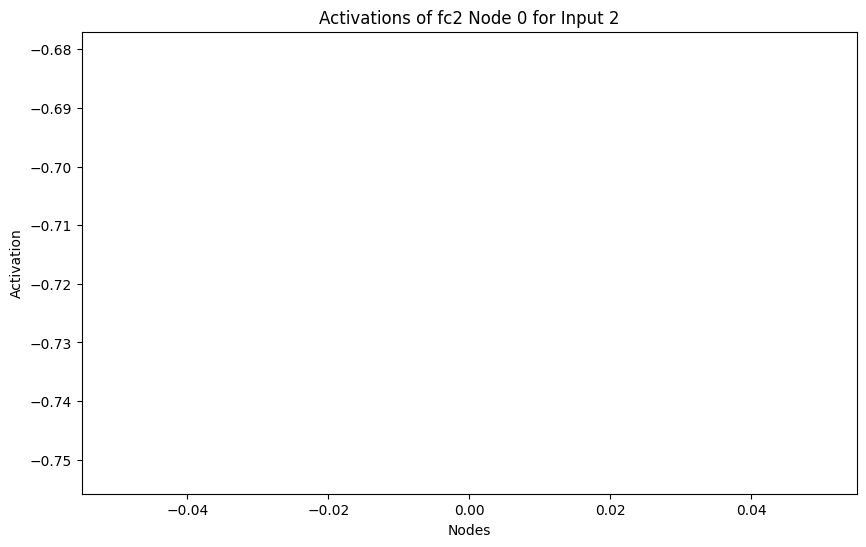

In [9]:
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
output_activations = model(images)
input_index = 2  # Index of the input for which we are visualizing activations
xNetwork.visualize_activations_for_input(input_index, 'fc2')

# You can also visualize for a specific node
node_index = 0
xNetwork.visualize_activations_for_input(input_index, 'fc2', node_index=node_index)

In [10]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchnum, shuffle=False)


def test_accuracy(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Step 3: Evaluate the Model
accuracy = test_accuracy(model, testloader)
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 94.69%
